## PART 4: MODEL DEVELOPMENT

In [21]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import pylab as py
import seaborn as sns

# libraries for model development (i think i'll use liner regression)
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

#Import dataframe
path = '../data/dataframe.csv'
df = pd.read_csv(path)

# INITIAL DATA MANIPUNATION
df['reference_date'] = pd.to_datetime(df['reference_date'], utc=True).dt.tz_localize(None) 
df = df.sort_values(by='reference_date') 
# Reindex the dataframe to include all timestamps
full_range = pd.date_range(df['reference_date'].min(),
                           df['reference_date'].max(),
                           freq='h')
df = df.set_index('reference_date').reindex(full_range)
# Interpolate missing values (linear ones)
df = df.interpolate(method='linear')
df = df.reset_index().rename(columns={'index': 'reference_date'})
df.set_index('reference_date', inplace=True)
df_filtered = df.loc[:'2025-09-22 23:00:00'] # Filter on last avaiable Price observation

#### 9. Feature Engineering
    - Create relevant features for modeling (time-based, interactions, lags)
    - Consider creating a "net demand" variable (demand minus renewable generation)
    - Engineer peak/off-peak indicators

In [22]:
# those kind of variables are always helpful in order to forecast time series
df_filtered['hour'] = df_filtered.index.hour
df_filtered['dayofweek'] = df_filtered.index.dayofweek   # Monday=0, Sunday=6
df_filtered['month'] = df_filtered.index.month
df_filtered['weekofyear'] = df_filtered.index.isocalendar().week

# Peak/off-peak indicator
df_filtered['is_peak'] = df_filtered['hour'].isin(range(7,10)) | df_filtered['hour'].isin(range(17,20))#7,8,9,10,17,18,19,20
df_filtered['is_offpeak'] = ~df_filtered['is_peak']

C:\Users\samue\AppData\Local\Temp\ipykernel_29776\2654466479.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['hour'] = df_filtered.index.hour
C:\Users\samue\AppData\Local\Temp\ipykernel_29776\2654466479.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['dayofweek'] = df_filtered.index.dayofweek   # Monday=0, Sunday=6
C:\Users\samue\AppData\Local\Temp\ipykernel_29776\2654466479.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

In [23]:
# minus all ren. generation
df_filtered['net_demand']=df_filtered['Demand_de'] - df_filtered['Solar_de'] - df_filtered['Wind_de']

# i also define lagged net demand to include the effect of autocorrelation, sometimes is very helpful
df_filtered['net_demand_lag1'] = df_filtered['net_demand'].shift(1)
df_filtered['net_demand_lag24'] = df_filtered['net_demand'].shift(24)

C:\Users\samue\AppData\Local\Temp\ipykernel_29776\1605916340.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['net_demand']=df_filtered['Demand_de'] - df_filtered['Solar_de'] - df_filtered['Wind_de']
C:\Users\samue\AppData\Local\Temp\ipykernel_29776\1605916340.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['net_demand_lag1'] = df_filtered['net_demand'].shift(1)
C:\Users\samue\AppData\Local\Temp\ipykernel_29776\1605916340.py:6: SettingWithCopyWarning: 
A value is trying to be 

In [24]:
# Interaction between demand and ren. can be helpful?
test_df = pd.DataFrame({
    'demand_solar_interaction': df_filtered['Demand_de'] * df_filtered['Solar_de'],
    'demand_wind_interaction': df_filtered['Demand_de'] * df_filtered['Wind_de'],
    'demand_temp_interaction': df_filtered['Demand_de'] * df_filtered['Temp_de']
})

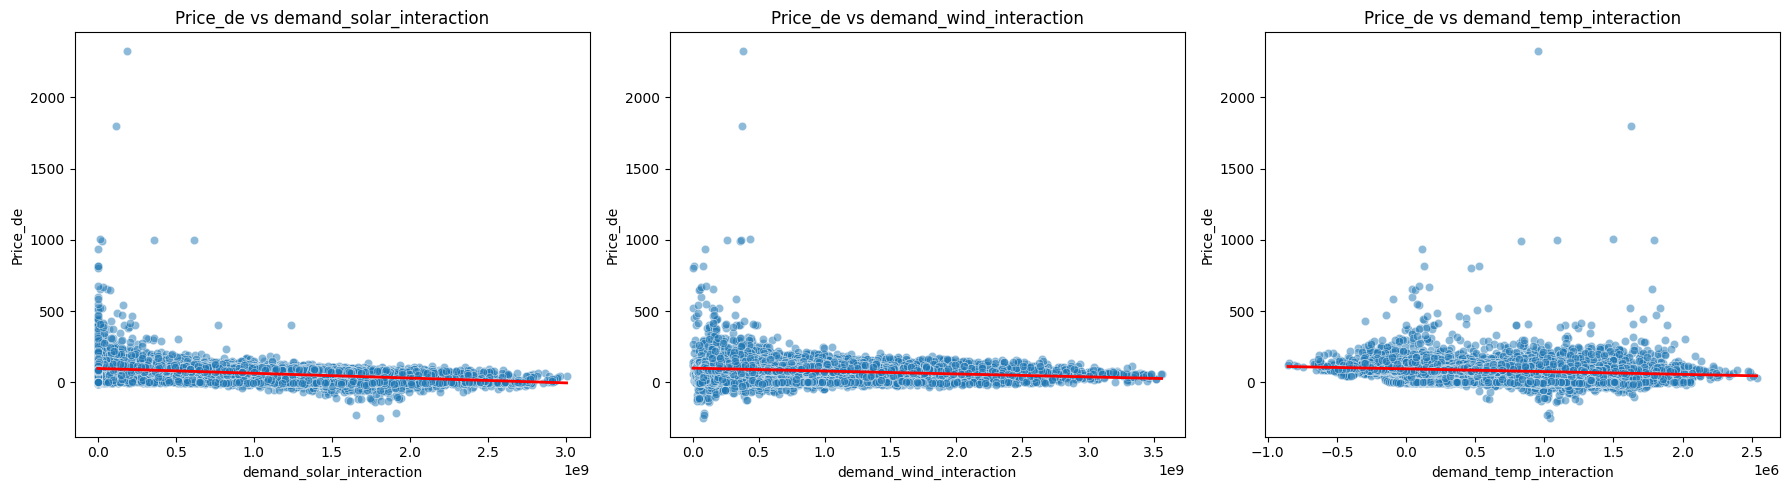

In [25]:
test_corr = [
    'demand_solar_interaction',
    'demand_wind_interaction',
    'demand_temp_interaction'
]

plt.figure(figsize=(18, 5))

for i, feature in enumerate(test_corr):
    plt.subplot(1, len(test_corr), i+1)
    sns.scatterplot(x=test_df[feature], y=df_filtered['Price_de'], alpha=0.5)
    sns.regplot(x=test_df[feature], y=df_filtered['Price_de'], scatter=False, color='red', line_kws={"linewidth":2})
    plt.xlabel(feature)
    plt.ylabel('Price_de')
    plt.title(f'Price_de vs {feature}')

plt.tight_layout()
plt.show()

<Axes: >

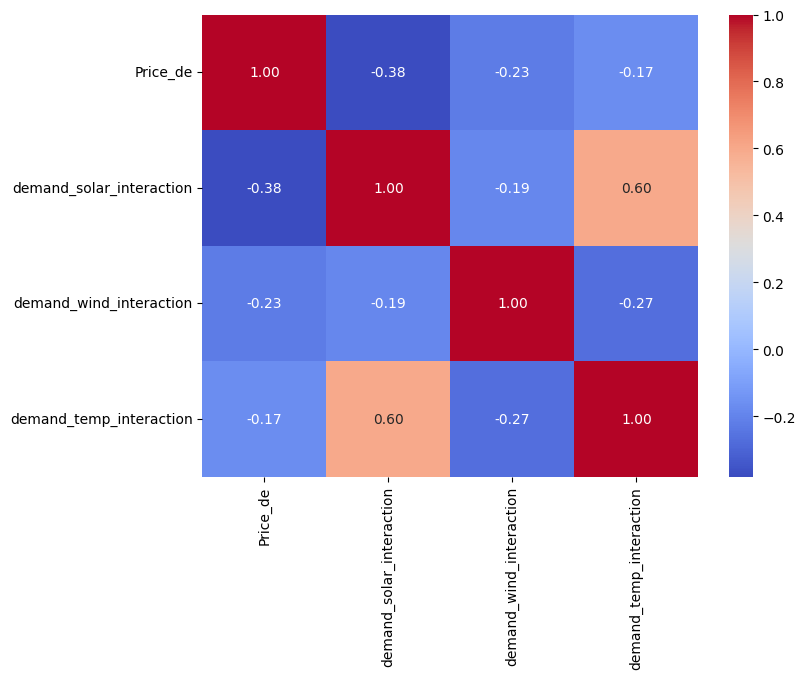

In [26]:
corr_df = pd.concat([df_filtered['Price_de'], test_df], axis=1)

plt.figure(figsize=(8,6))
sns.heatmap(corr_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")

Not very helpful, i will not use them

In [27]:
# lagged featues dor price (already prove haigh correlation with ACF)
df_filtered['Price_de_lag1'] = df_filtered['Price_de'].shift(1)
df_filtered['Price_de_lag24'] = df_filtered['Price_de'].shift(24)
df_filtered['Price_de_lag48'] = df_filtered['Price_de'].shift(48)

C:\Users\samue\AppData\Local\Temp\ipykernel_29776\1909467514.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Price_de_lag1'] = df_filtered['Price_de'].shift(1)
C:\Users\samue\AppData\Local\Temp\ipykernel_29776\1909467514.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Price_de_lag24'] = df_filtered['Price_de'].shift(24)
C:\Users\samue\AppData\Local\Temp\ipykernel_29776\1909467514.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

#### 10. Predictive Modeling
    - Build a model to predict Price_de using the fundamental variables
    - Which variables are most important for price prediction?
    - How well does your model capture peak hour price spikes?

In [28]:
# Features
features = [
    'Price_de_lag1', 'Price_de_lag24', 'Price_de_lag48',
    'Demand_de', 'Solar_de', 'Wind_de', 'Temp_de',
    'Coal_de', 'Lignite_de', 'Gas_de',
    'Demand_at', 'Demand_be', 'Demand_ch', 'Demand_fr', 'Demand_nl', #'Demand_dk',
    #'demand_solar_interaction', 'demand_wind_interaction', 'demand_temp_interaction',
    'hour', 'dayofweek', 'month', 'is_peak',
    'net_demand', 'net_demand_lag1', 'net_demand_lag24'
]

# Target
target = 'Price_de'
# COvariates
X = df_filtered[features]

y = df_filtered[target]

In [29]:
# Count missing observations for each covariate
for col in X.columns:
    missing_count = X[col].isna().sum()
    print(f"{col}: {missing_count} missing values")

Price_de_lag1: 1 missing values
Price_de_lag24: 24 missing values
Price_de_lag48: 48 missing values
Demand_de: 0 missing values
Solar_de: 0 missing values
Wind_de: 0 missing values
Temp_de: 0 missing values
Coal_de: 0 missing values
Lignite_de: 0 missing values
Gas_de: 0 missing values
Demand_at: 0 missing values
Demand_be: 0 missing values
Demand_ch: 0 missing values
Demand_fr: 0 missing values
Demand_nl: 0 missing values
hour: 0 missing values
dayofweek: 0 missing values
month: 0 missing values
is_peak: 0 missing values
net_demand: 0 missing values
net_demand_lag1: 1 missing values
net_demand_lag24: 24 missing values


Those missing make perfect sense, due to the nature of lagged variables!

In [30]:
# mean value for NaN values in covariate dataset (lazy but effective)
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y, test_size=0.2, shuffle=False  # keep time order!!!!!!!!
)

In [32]:
scaler = StandardScaler() # i could have tried maxmin scaler
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [33]:
model = LinearRegression()
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE:{mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R^2:{r2:.3f}")

MAE:9.52
RMSE: 16.29
R^2:0.902


In [34]:
coef_df = (
    pd.DataFrame({
        "Feature": X.columns,
        "Coefficient": model.coef_
    })
    .sort_values(by="Coefficient", ascending=False)
)

print(coef_df)

             Feature  Coefficient
0      Price_de_lag1    45.847704
19        net_demand    30.159633
3          Demand_de     9.200070
10         Demand_at     5.185219
1     Price_de_lag24     4.150417
6            Temp_de     1.842548
2     Price_de_lag48     1.227011
13         Demand_fr     0.558707
12         Demand_ch     0.557142
17             month     0.425324
15              hour     0.176707
9             Gas_de     0.150154
11         Demand_be    -0.238139
16         dayofweek    -0.249445
7            Coal_de    -0.256348
18           is_peak    -0.393571
8         Lignite_de    -0.744447
14         Demand_nl    -0.901640
21  net_demand_lag24    -2.114965
4           Solar_de   -15.216063
5            Wind_de   -16.059605
20   net_demand_lag1   -40.949558


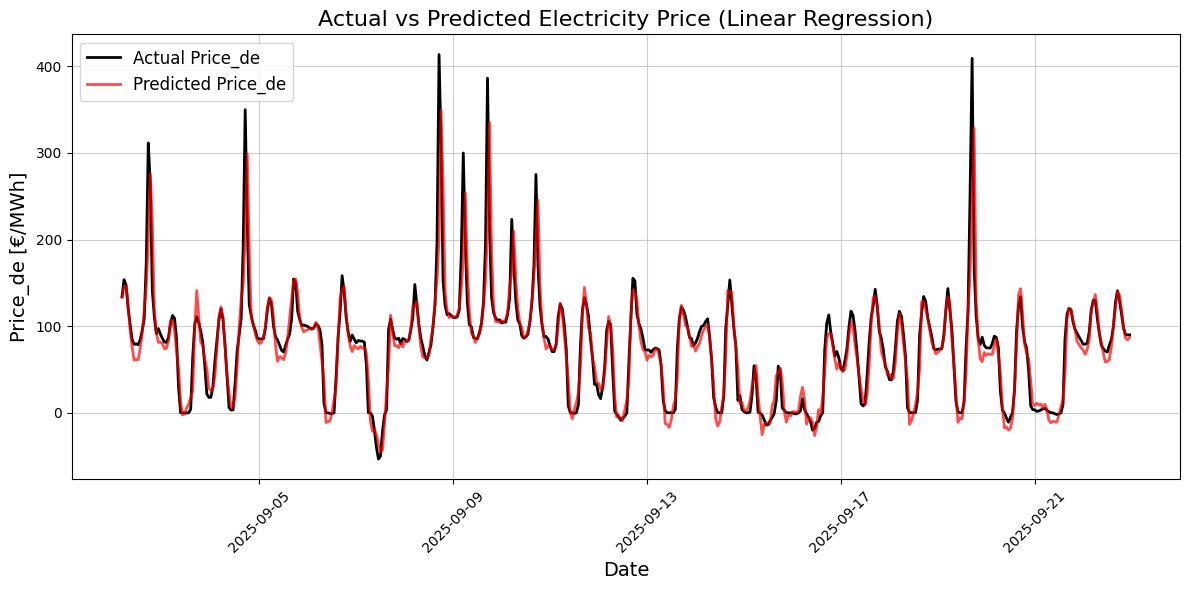

In [35]:
#most recent observations to visualize
n = 500

#plot riciclato dalla tesi
y_test_last_n = y_test[-n:].values
y_pred_last_n = y_pred[-n:]
dates_last_n = y_test.index[-n:]

plt.figure(figsize=(12, 6))
plt.plot(dates_last_n, y_test_last_n, label='Actual Price_de', color='black', linewidth=2)
plt.plot(dates_last_n, y_pred_last_n, label='Predicted Price_de', color='red', linewidth=2, alpha=0.7)

plt.title('Actual vs Predicted Electricity Price (Linear Regression)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price_de [€/MWh]', fontsize=14)
plt.xticks(rotation=45)
plt.legend(fontsize=12)
plt.grid(alpha=0.6)
plt.tight_layout()
plt.show()



We could have added a fancy probabilistic forecasting model, but plain linear regression works well

**How well does your model capture peak hour price spikes?**

In [40]:
#as before...
hourly_median = df_filtered.groupby('hour')['Price_de'].median() 
morning_peak_hour = hourly_median.loc[4:8].idxmax()
evening_peak_hour = hourly_median.loc[17:20].idxmax()#5-8 Pome 
morning_peak_price = hourly_median[morning_peak_hour] 
evening_peak_price = hourly_median[evening_peak_hour] 
daily_min_price = hourly_median.min() 

# magnitud of those spikes (by difference) 
morning_spike = morning_peak_price - daily_min_price 
evening_spike = evening_peak_price - daily_min_price 
print(f"Morning peak hour: {morning_peak_hour}h, magnitude: {morning_spike:.2f} €/MWh") 
print(f"Evening peak hour: {evening_peak_hour}h, magnitude: {evening_spike:.2f} €/MWh")

Morning peak hour: 5h, magnitude: 53.42 €/MWh
Evening peak hour: 18h, magnitude: 77.20 €/MWh


In [41]:
X_test_df = pd.DataFrame(X_test, columns=features, index=y_test.index) 
# Masks for peak hours...
morning_peak_mask = X_test_df['hour'] == morning_peak_hour
evening_peak_mask = X_test_df['hour'] == evening_peak_hour

y_morning_actual = y_test[morning_peak_mask]
y_morning_pred = y_pred[morning_peak_mask]

y_evening_actual = y_test[evening_peak_mask]
y_evening_pred = y_pred[evening_peak_mask]

# Evaluate peak--predictions
morning_mae = mean_absolute_error(y_morning_actual, y_morning_pred)
morning_rmse = np.sqrt(mean_squared_error(y_morning_actual, y_morning_pred))
evening_mae = mean_absolute_error(y_evening_actual, y_evening_pred)
evening_rmse = np.sqrt(mean_squared_error(y_evening_actual, y_evening_pred))

print(f"Morning peak---->MAE: {morning_mae:.2f} and RMSE: {morning_rmse:.2f}")
print(f"Evening peak----> MAE: {evening_mae:.2f} andd RMSE: {evening_rmse:.2f}")

Morning peak---->MAE: 7.60 and RMSE: 14.02
Evening peak----> MAE: 18.44 andd RMSE: 33.57


- **Morning peak** ---->Errors are relatively low compared to the spike magnitude (53.42 €/MWh).
- **Evening peak** ---->Errors are larger, the model struggles more with the evening spike, probably non-linear effect that a linear model cannot fully capture!

Overall, it seems that the linear regression performs decently.